<a href="https://colab.research.google.com/github/olakoja/Priozersk/blob/main/%D0%93%D1%80%D0%B0%D1%84_%D1%81%D0%B2%D1%8F%D0%B7%D0%BD%D0%BE%D1%81%D1%82%D0%B8_%D0%9F%D1%80%D0%B8%D0%BE%D0%B7%D0%B5%D1%80%D1%81%D0%BA_3_%D0%BA%D0%BE%D0%BD%D1%86%D0%B5%D0%BF%D1%86%D0%B8%D1%8F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Библиотеки и ввод данных

In [ ]:
pip install blocksnet ipykernel -q

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 82.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.8/277.8 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 77.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.1/255.1 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.9/38.9 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 91.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 61.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━

In [ ]:
import geopandas as gpd
import os

In [ ]:
data_path = '/content/data'

In [ ]:
blocks = gpd.read_file(os.path.join(data_path, 'blocks3.geojson'))

In [ ]:
blocks = blocks.explode(index_parts=True).reset_index(drop=True)

In [ ]:
from iduedu import get_boundary

In [ ]:
# bounds = gpd.read_file(os.path.join(data_path, 'круг.gpkg')) - когда есть файл

bounds = get_boundary(osm_id = 1547522) #применять, если надо получить полигон из осм

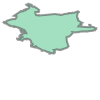

In [ ]:
bounds

# Получаем первый полный граф

In [ ]:
from iduedu import get_drive_graph
G_drive = get_drive_graph(polygon = bounds, additional_edgedata= ["highway", "maxspeed", "reg", "ref", "name"])

Дополняем дорогами гипотезы

In [ ]:
roads_gdf = gpd.read_file("/content/roads8.geojson")

In [ ]:
print(roads_gdf.geom_type.unique())

['MultiLineString']


Упрощаем геометрию

In [ ]:
roads_gdf = roads_gdf.explode(index_parts=True).reset_index(drop=True)

In [ ]:
print(roads_gdf.geom_type.unique())

['LineString']


Эти бибилиотеки тоже надо

In [ ]:
import networkx as nx
from shapely.geometry import Point, LineString, MultiLineString

In [ ]:
import pandas as pd

# Совместить графы

In [ ]:
# Делаем одинаковые crs
roads_gdf = roads_gdf.to_crs(G_drive.graph['crs'])  # Приведение CRS к CRS G_drive

In [ ]:
# Делаем узлы для графа из геодатафрейма
nodes = []
# Извлечение координат непосредственно в основном цикле
for geom in roads_gdf.geometry:
    if isinstance(geom, LineString):
        nodes.extend(list(geom.coords))  # Добавляем координаты LineString
    elif isinstance(geom, MultiLineString):
        for line in geom:
            nodes.extend(list(line.coords))  # Добавляем координаты каждого Line в MultiLineString

In [ ]:
# Удаляем дубликаты
unique_nodes = list(set(nodes))

In [ ]:
# 3. Создайте маппинг узлов к идентификаторам (если честно, сама не сильно вкурсе, что такое "маппинг")
nodes_gdf['node_id'] = range(len(nodes_gdf))

In [ ]:
# Создаём столбцы `u` и `v` для рёбер, номер точки начала и конца
def get_node_ids(row):
    coords = list(row.geometry.coords)
    start_node = Point(coords[0])
    end_node = Point(coords[-1])

    u = nodes_gdf[nodes_gdf.geometry == start_node].node_id.values[0]
    v = nodes_gdf[nodes_gdf.geometry == end_node].node_id.values[0]

    return pd.Series([u, v])

roads_gdf[['u', 'v']] = roads_gdf.apply(get_node_ids, axis=1)

In [ ]:
# Вычислям длину рёбер, если она не указана
if 'length_meter' not in roads_gdf.columns:
    roads_gdf['length_meter'] = roads_gdf.geometry.length

# 6. Создайте уникальный ключ для каждого ребра
roads_gdf['key'] = roads_gdf.index

# 7. Создайте новый GeoDataFrame для рёбер
edges_gdf = roads_gdf[['u', 'v', 'key', 'length_meter', 'geometry']]

# Проверка результата
print(edges_gdf.head())

     u   v  key  length_meter  \
0  118  83    0     48.901377   
1  120  31    1     71.813772   
2   31  30    2     72.645286   
3   52  30    3     80.444740   
4   30  53    4     29.807199   

                                            geometry  
0  LINESTRING Z (345334.773 6767660.754 0.000, 34...  
1  LINESTRING Z (345221.400 6767671.722 0.000, 34...  
2  LINESTRING Z (345273.229 6767721.432 0.000, 34...  
3  LINESTRING Z (345387.683 6767720.493 0.000, 34...  
4  LINESTRING Z (345325.656 6767771.718 0.000, 34...  


In [ ]:
# Посмотрим, что у нас есть для графа
roads_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 154 entries, 0 to 153
Data columns (total 44 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   access                      0 non-null      object  
 1   gauge                       0 non-null      object  
 2   electrified                 0 non-null      object  
 3   man_made                    0 non-null      object  
 4   passenger_lines             0 non-null      object  
 5   power                       0 non-null      object  
 6   sidewalk                    0 non-null      object  
 7   ref                         0 non-null      object  
 8   smoothness                  0 non-null      object  
 9   substance                   0 non-null      object  
 10  engineering_type            0 non-null      object  
 11  surface                     0 non-null      object  
 12  lit                         0 non-null      object  
 13  old_ref     

In [ ]:
edges_gdf = roads_gdf[['u', 'v', 'key', 'length_meter', 'geometry', "highway", "maxspeed", "ref", "name"]]

In [ ]:
# Создаем GeoDataFrame для узлов
nodes_gdf = gpd.GeoDataFrame(geometry=[Point(xy) for xy in unique_nodes], crs=roads_gdf.crs)

# Добавляем столбцы x и y
nodes_gdf['x'] = nodes_gdf.geometry.x
nodes_gdf['y'] = nodes_gdf.geometry.y

In [ ]:
edges_gdf.set_index(['u', 'v', 'key'], inplace=True)

In [ ]:
import osmnx as ox
import matplotlib.pyplot as plt

In [ ]:
# Создаём новый граф из геодатафрейма граф

new_graph = ox.graph_from_gdfs(nodes_gdf, edges_gdf)

In [ ]:
# Объединеняем графы
G_drive = nx.compose(G_drive, new_graph)

# Что получилось?
print(f"Total nodes in G_drive: {G_drive.number_of_nodes()}")
print(f"Total edges in G_drive: {G_drive.number_of_edges()}")


Total nodes in G_drive: 474
Total edges in G_drive: 1039


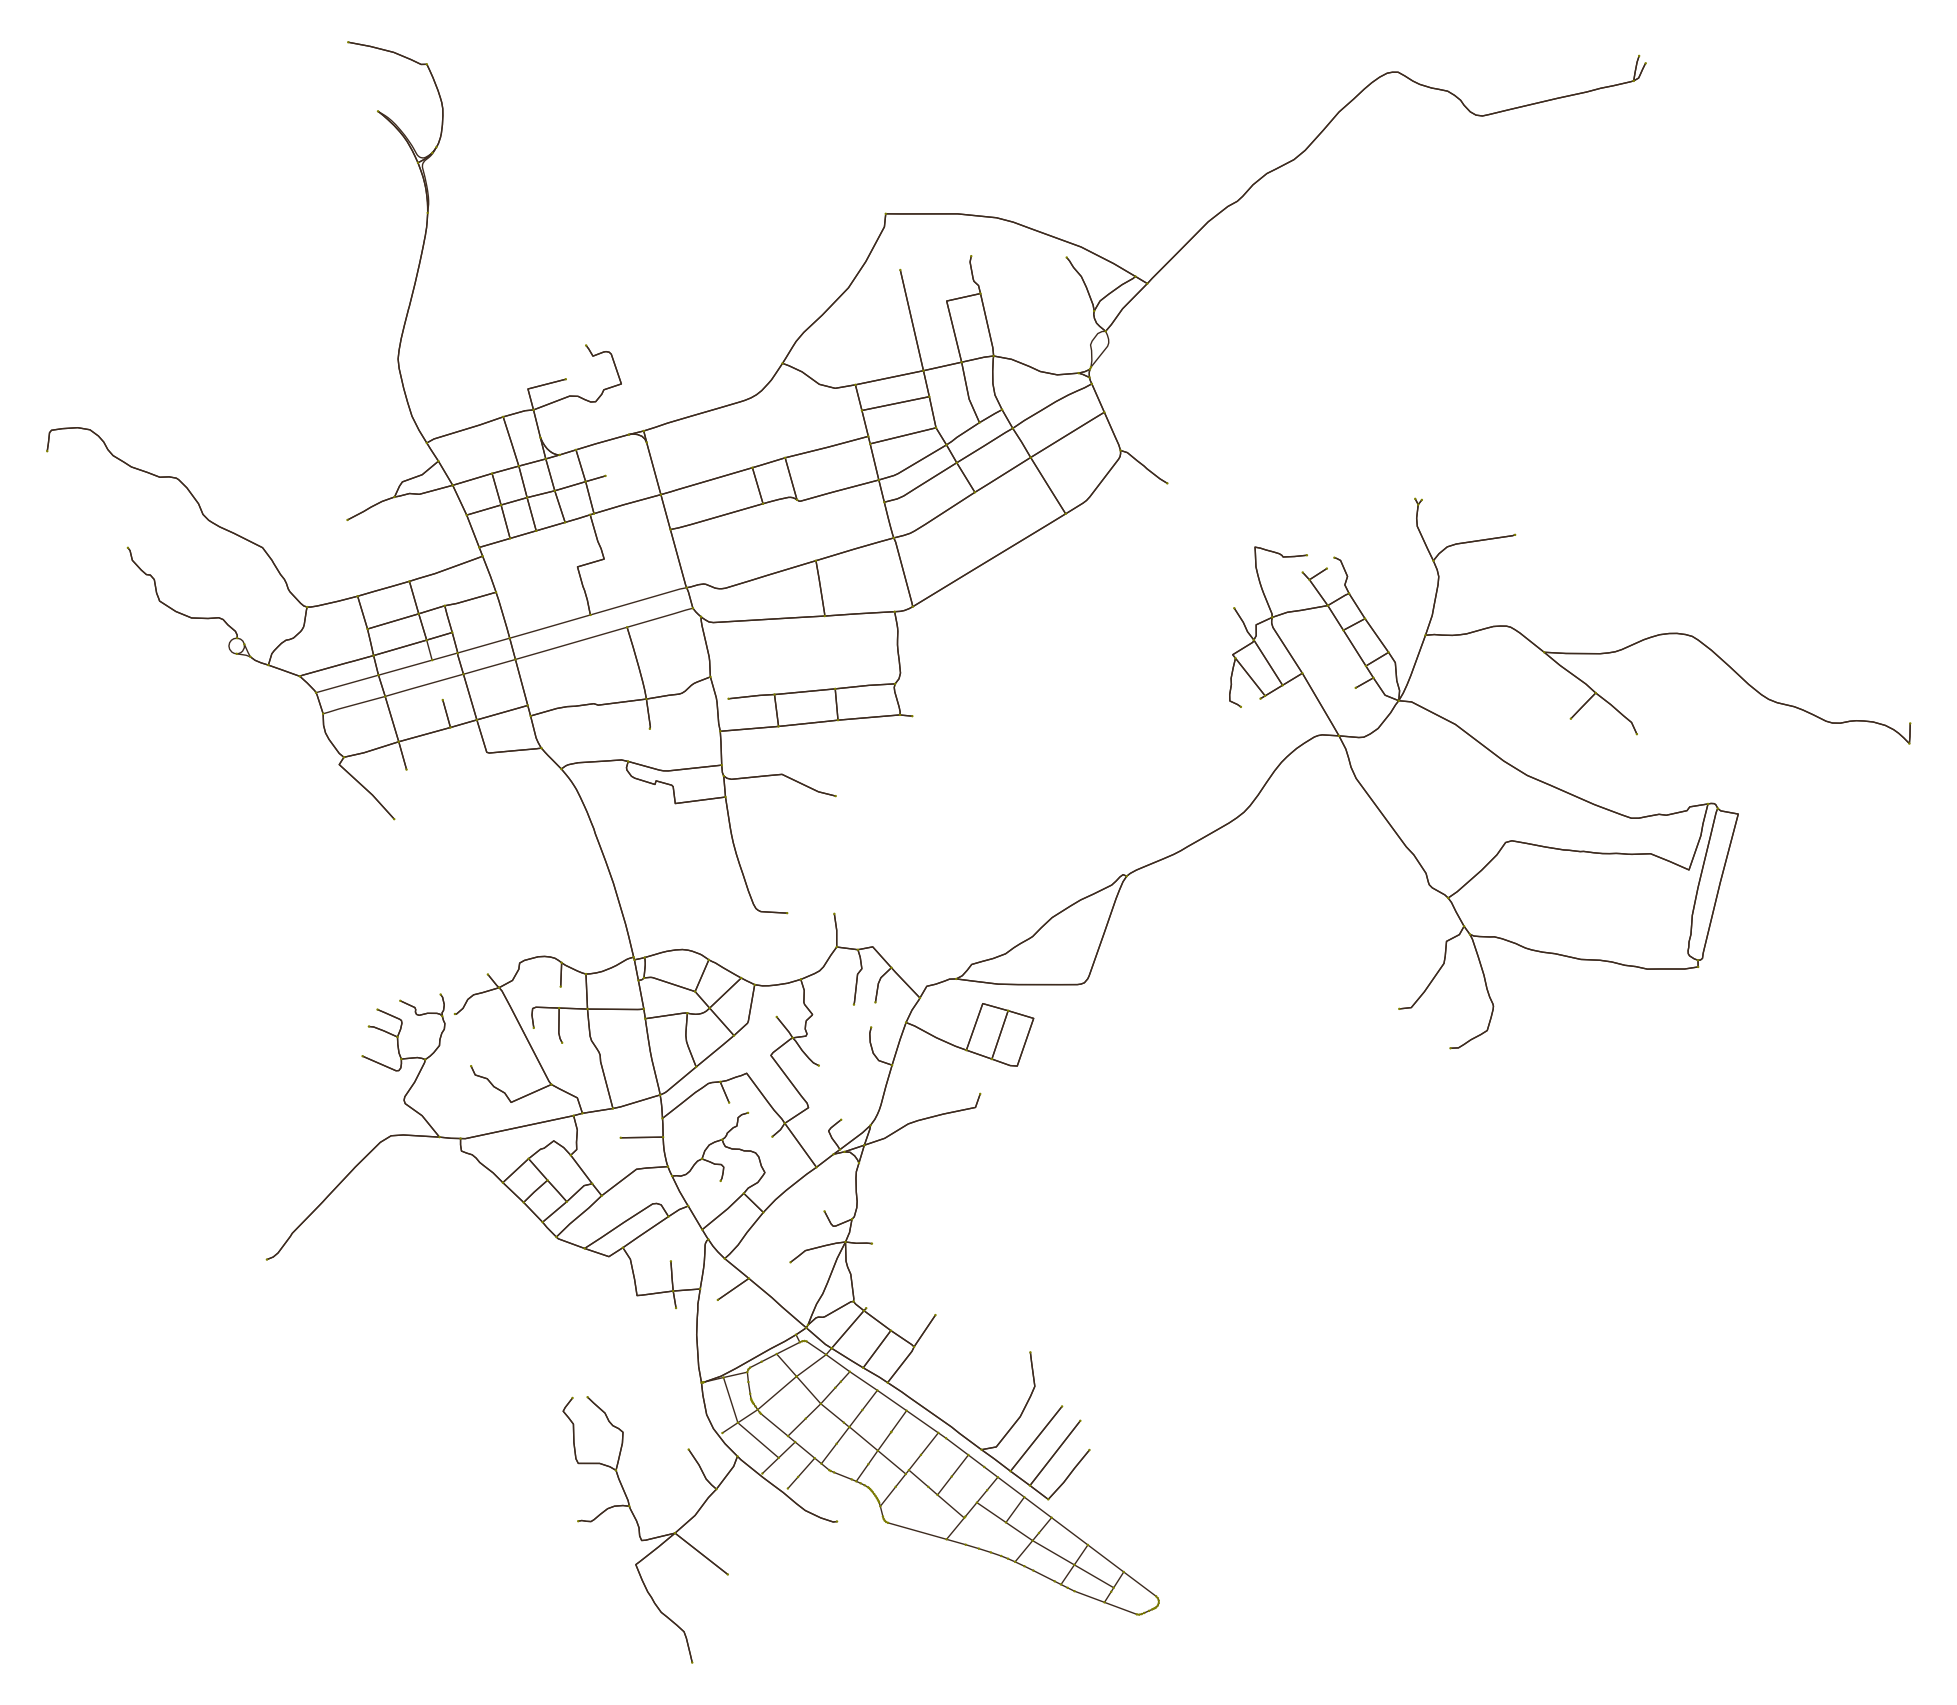

In [ ]:
# Создайте график
fig, ax = ox.plot_graph(G_drive,
                         node_color="#808000",  # цвет вершин
                         edge_color="#3d2b1f",  # цвет ребер
                         bgcolor="white",  # цвет подложки
                         node_size=3,  # размер верщин
                         edge_linewidth=1,  # толщина ребер
                         figsize=(25, 25))  # размер картинки

# Сохраните изображение
fig.savefig(os.path.join('graph_image.png'))

 # Теперь надо заполнить недостающие данные

Что есть в новом графе? Если в нём нет каких-то данных, то в новом конкретно для его ребёр данных таких не будет

In [ ]:
n,e = ox.graph_to_gdfs(new_graph)

In [ ]:
e

length_meter  time_min  \
u          v          key                           
262105     9836778650 0      758.780000     0.506   
           1240718738 0       68.709000     0.046   
           268095141  0      256.919000     0.385   
9836778650 1970665310 0      163.336000     0.109   
           9835123731 0      227.027000     0.227   
...                                 ...       ...   
115        60         145     54.159007       NaN   
88         115        147     63.079217       NaN   
44         88         148     88.682880       NaN   
103        36         150     82.720658       NaN   
36         81         151    122.959258       NaN   

                                                                    geometry  \
u          v          key                                                      
262105     9836778650 0    LINESTRING (344155.508 6770944.822, 344141.780...   
           1240718738 0    LINESTRING (344155.508 6770944.822, 344158.404...   
           268095141  0    LINESTRING (344155.508 6770944.822, 344173.854...   
9836778650 1970665310 0    LINESTRING (344158.365 6771675.564, 344158.210...   
           9835123731 0    LINESTRING (344158.365 6771675.564, 344161.314...   
...                                                                      ...   
115        60         145  LINESTRING Z (345926.031 6767692.561 0.000, 34...   
88         115        147  LINESTRING Z (345875.639 6767730.503 0.000, 34...   
44         88         148  LINESTRING Z (345804.776 6767783.823 0.000, 34...   
103        36         150  LINESTRING Z (345631.133 6767804.189 0.000, 34...   
36         81         151  LINESTRING Z (345679.439 6767871.339 0.000, 34...   

                                 highway     maxspeed  reg    ref  \
u          v          key                                           
262105     9836778650 0            trunk  1500.000000  1.0  А-121   
           1240718738 0            trunk  1500.000000  1.0  А-121   
           268095141  0     unclassified   666.666667  3.0    NaN   
9836778650 1970665310 0            trunk  1500.000000  1.0  А-121   
           9835123731 0    tertiary_link  1000.000000  3.0    NaN   
...                                  ...          ...  ...    ...   
115        60         145      secondary          NaN  NaN    NaN   
88         115        147      secondary          NaN  NaN    NaN   
44         88         148      secondary          NaN  NaN    NaN   
103        36         150      secondary          NaN  NaN    NaN   
36         81         151      secondary          NaN  NaN    NaN   

                                                         name  
u          v          key                                      
262105     9836778650 0    [Сортавальское шоссе, «Сортавала»]  
           1240718738 0                 Красноармейская улица  
           268095141  0                        Песочная улица  
9836778650 1970665310 0                           «Сортавала»  
           9835123731 0                                   NaN  
...                                                       ...  
115        60         145                                 NaN  
88         115        147                                 NaN  
44         88         148                                 NaN  
103        36         150                                 NaN  
36         81         151                                 NaN  

[1039 rows x 8 columns]

In [ ]:
e

length_meter                                           geometry  \
u   v   key                                                                    
118 83  0       48.901377  LINESTRING Z (345334.773 6767660.754 0.000, 34...   
120 31  1       71.813772  LINESTRING Z (345221.400 6767671.722 0.000, 34...   
31  30  2       72.645286  LINESTRING Z (345273.229 6767721.432 0.000, 34...   
    101 9      171.062796  LINESTRING Z (345273.229 6767721.432 0.000, 34...   
30  53  4       29.807199  LINESTRING Z (345325.656 6767771.718 0.000, 34...   
...                   ...                                                ...   
115 60  145     54.159007  LINESTRING Z (345926.031 6767692.561 0.000, 34...   
88  115 147     63.079217  LINESTRING Z (345875.639 6767730.503 0.000, 34...   
44  88  148     88.682880  LINESTRING Z (345804.776 6767783.823 0.000, 34...   
103 36  150     82.720658  LINESTRING Z (345631.133 6767804.189 0.000, 34...   
36  81  151    122.959258  LINESTRING Z (345679.439 6767871.339 0.000, 34...   

               highway  
u   v   key             
118 83  0    secondary  
120 31  1    secondary  
31  30  2    secondary  
    101 9    secondary  
30  53  4    secondary  
...                ...  
115 60  145  secondary  
88  115 147  secondary  
44  88  148  secondary  
103 36  150  secondary  
36  81  151  secondary  

[154 rows x 3 columns]

In [ ]:
import pandas as pd
import networkx as nx

Получаем максимальную скорость

Сперва создаём поле

In [ ]:
for u, v, data in new_graph.edges(data=True):
   if 'maxspeed' not in data:
        data['maxspeed'] = None
        print(data['maxspeed'])

In [ ]:
n,e = ox.graph_to_gdfs(new_graph)

In [ ]:
e.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 154 entries, (118, 83, 0) to (36, 81, 151)
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   length_meter  154 non-null    float64 
 1   geometry      154 non-null    geometry
 2   highway       154 non-null    object  
 3   maxspeed      0 non-null      object  
dtypes: float64(1), geometry(1), object(2)
memory usage: 21.3+ KB


Заполняем поле

In [ ]:
from collections import defaultdict

# Словарь для хранения сумм и количества maxspeed для каждой категории highway
highway_stats = defaultdict(lambda: {'total': 0, 'count': 0})

# Сбор данных о maxspeed для каждой категории highway
for u, v, data in G_drive.edges(data=True):
    highway_categories = data.get('highway')
    maxspeed_value = data.get('maxspeed')

    # Проверяем, что maxspeed существует и не равно None или пустой строке
    if maxspeed_value not in [None, '']:
        if isinstance(highway_categories, list):
            for category in highway_categories:
                highway_stats[category]['total'] += maxspeed_value
                highway_stats[category]['count'] += 1
        else:
            highway_stats[highway_categories]['total'] += maxspeed_value
            highway_stats[highway_categories]['count'] += 1

# Создаем словарь средних значений maxspeed
average_maxspeeds = {}
for highway_category, stats in highway_stats.items():
    if stats['count'] > 0:
        average_maxspeed = stats['total'] / stats['count']
        average_maxspeeds[highway_category] = average_maxspeed

# Обновляем maxspeed для рёбер с пустыми значениями maxspeed
for u, v, data in G_drive.edges(data=True):
    maxspeed_value = data.get('maxspeed')

    # Устанавливаем maxspeed в 500, если highway = secondary
    if isinstance(data.get('highway'), list):
        if 'secondary' in data['highway']:
            data['maxspeed'] = 500
    elif data.get('highway') == 'secondary':
        data['maxspeed'] = 500

    if maxspeed_value in [None, '']:  # Если maxspeed пустое
        highway_category = data.get('highway')

        if isinstance(highway_category, list):
            # Если highway - список, берем первое соответствующее значение
            for category in highway_category:
                if category in average_maxspeeds:
                    data['maxspeed'] = average_maxspeeds[category]  # Устанавливаем среднее значение maxspeed
                    break  # Прерываем, если нашли подходящее значение
        elif highway_category in average_maxspeeds:
            data['maxspeed'] = average_maxspeeds[highway_category]  # Устанавливаем среднее значение maxspeed

# Проверка и вывод обновленного графа
for u, v, data in G_drive.edges(data=True):
    print(f"Edge from {u} to {v}: highway = {data.get('highway', 'unknown')}, maxspeed = {data['maxspeed']}")


Edge from 262105 to 9836778650: highway = trunk, maxspeed = 1500.0
Edge from 262105 to 1240718738: highway = trunk, maxspeed = 1500.0
Edge from 262105 to 268095141: highway = unclassified, maxspeed = 666.6666666666666
Edge from 9836778650 to 1970665310: highway = trunk, maxspeed = 1500.0
Edge from 9836778650 to 9835123731: highway = tertiary_link, maxspeed = 1000.0
Edge from 9836778650 to 262105: highway = trunk, maxspeed = 1500.0
Edge from 1240718738 to 262107: highway = trunk, maxspeed = 1500.0
Edge from 1240718738 to 262105: highway = trunk, maxspeed = 1500.0
Edge from 1240718738 to 5794407097: highway = residential, maxspeed = 666.0619803477102
Edge from 268095141 to 473471702: highway = residential, maxspeed = 666.0619803477102
Edge from 268095141 to 262105: highway = unclassified, maxspeed = 666.6666666666666
Edge from 268095141 to 257415437: highway = unclassified, maxspeed = 666.6666666666666
Edge from 262107 to 262108: highway = trunk, maxspeed = 1500.0
Edge from 262107 to 124

Смотрим результат

In [ ]:
n,e = ox.graph_to_gdfs(G_drive)

In [ ]:
e.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 1039 entries, (262105, 9836778650, 0) to (36, 81, 151)
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   length_meter  1039 non-null   float64 
 1   time_min      885 non-null    float64 
 2   geometry      1039 non-null   geometry
 3   highway       1039 non-null   object  
 4   maxspeed      1039 non-null   float64 
 5   reg           885 non-null    float64 
 6   ref           82 non-null     object  
 7   name          673 non-null    object  
dtypes: float64(4), geometry(1), object(3)
memory usage: 116.1+ KB


Заполняем минимальное время в пути

In [ ]:
# Обновляем рёбра для добавления значения time_min, если его нет
for u, v, data in G_drive.edges(data=True):
    # Проверяем наличие ключа time_min
    if 'time_min' not in data:
        # Получаем значения maxspeed и length_meter
        maxspeed_value = data.get('maxspeed')
        length_meter_value = data.get('length_meter')

        # Проверяем, что maxspeed и length_meter существуют и length_meter не равно 0
        if maxspeed_value is not None and length_meter_value is not None and length_meter_value > 0:
            # Вычисляем time_min и округляем до 6 знаков после запятой
            time_min_value = round(maxspeed_value / length_meter_value, 6)
            # Создаем ключ time_min и присваиваем ему значение
            data['time_min'] = time_min_value

# Проверка и вывод обновленного графа
for u, v, data in G_drive.edges(data=True):
    print(f"Edge from {u} to {v}: maxspeed = {data.get('maxspeed', 'unknown')}, length_meter = {data.get('length_meter', 'unknown')}, time_min = {data.get('time_min', 'unknown')}")


Edge from 262105 to 9836778650: maxspeed = 1500.0, length_meter = 758.78, time_min = 0.506
Edge from 262105 to 1240718738: maxspeed = 1500.0, length_meter = 68.709, time_min = 0.046
Edge from 262105 to 268095141: maxspeed = 666.6666666666666, length_meter = 256.919, time_min = 0.385
Edge from 9836778650 to 1970665310: maxspeed = 1500.0, length_meter = 163.336, time_min = 0.109
Edge from 9836778650 to 9835123731: maxspeed = 1000.0, length_meter = 227.027, time_min = 0.227
Edge from 9836778650 to 262105: maxspeed = 1500.0, length_meter = 758.78, time_min = 0.506
Edge from 1240718738 to 262107: maxspeed = 1500.0, length_meter = 89.077, time_min = 0.059
Edge from 1240718738 to 262105: maxspeed = 1500.0, length_meter = 68.709, time_min = 0.046
Edge from 1240718738 to 5794407097: maxspeed = 666.0619803477102, length_meter = 188.313, time_min = 0.282
Edge from 268095141 to 473471702: maxspeed = 666.0619803477102, length_meter = 164.068, time_min = 0.246
Edge from 268095141 to 262105: maxspeed

Смотрим результат

In [ ]:
n,e = ox.graph_to_gdfs(G_drive)

In [ ]:
e.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 1039 entries, (262105, 9836778650, 0) to (36, 81, 151)
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   length_meter  1039 non-null   float64 
 1   time_min      1039 non-null   float64 
 2   geometry      1039 non-null   geometry
 3   highway       1039 non-null   object  
 4   maxspeed      1039 non-null   float64 
 5   reg           885 non-null    float64 
 6   ref           82 non-null     object  
 7   name          673 non-null    object  
dtypes: float64(4), geometry(1), object(3)
memory usage: 116.1+ KB


Сохраняем в файлы

In [ ]:
n.to_file("nodes.geojson")
e.to_file("edges.shp", encoding='utf-8')

<ipython-input-82-17b6872e9029>:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  e.to_file("edges.shp", encoding='utf-8')


#Создаём матрицу по заполненному графу

In [ ]:
from blocksnet import AccessibilityProcessor
AccessibilityProcessor._fix_graph(G_drive)

In [ ]:
ap = AccessibilityProcessor(blocks)

Ругается на систему координат и проекцию. Посмотрим

In [ ]:
# Проверка CRS для GeoDataFrame
print("CRS для gdf_from:", blocks.crs)
print("CRS для gdf_from:", roads_gdf.crs)
print("CRS для графа:", G_drive.graph["crs"])

# Убедитесь, что все CRS совпадают
if blocks.crs != roads_gdf.crs or roads_gdf.crs != G_drive.graph["crs"]:
    print("CRS не совпадают! Исправьте CRS для всех объектов.")
else:
    print("Все CRS совпадают.")

CRS для gdf_from: EPSG:32636
CRS для gdf_from: EPSG:32636
CRS для графа: EPSG:32636
Все CRS совпадают.


In [ ]:
import pyproj

Отладочный код от нейросети. Честно, я тиакое не напишу

In [ ]:
# 1. Сначала проверим все CRS перед обработкой
print("=== Исходные CRS ===")
print(f"blocks.crs: {blocks.crs}")
print(f"G_drive.graph['crs']: {G_drive.graph['crs']}")

# 2. Попробуем явно установить CRS для всех компонентов
from pyproj import CRS
target_crs = CRS.from_epsg(32636)

# 3. Преобразуем blocks
blocks = blocks.to_crs(target_crs)

# 4. Установим CRS для графа
G_drive.graph['crs'] = 32636

# 5. Проверим CRS после преобразования
print("\n=== CRS после преобразования ===")
print(f"blocks.crs: {blocks.crs}")
print(f"G_drive.graph['crs']: {G_drive.graph['crs']}")

# 6. Проверим тип данных CRS
print("\n=== Типы данных CRS ===")
print(f"Type of blocks.crs: {type(blocks.crs)}")
print(f"Type of G_drive.graph['crs']: {type(G_drive.graph['crs'])}")

# 7. Попробуем создать AccessibilityProcessor с подробным выводом
try:
    print("\n=== Создание AccessibilityProcessor ===")
    ap = AccessibilityProcessor(blocks)
    print("AccessibilityProcessor создан успешно")

    print("\n=== Попытка получить матрицу доступности ===")
    acc_mx = ap.get_accessibility_matrix(G_drive)
    print("Матрица доступности создана успешно")
except Exception as e:
    print(f"\nПроизошла ошибка: {type(e).name}")
    print(f"Текст ошибки: {str(e)}")
    print(f"Требуемый CRS: {getattr(e, 'required_crs', 'Не указан')}")

=== Исходные CRS ===
blocks.crs: EPSG:32636
G_drive.graph['crs']: EPSG:32636

=== CRS после преобразования ===
blocks.crs: EPSG:32636
G_drive.graph['crs']: 32636

=== Типы данных CRS ===
Type of blocks.crs: <class 'pyproj.crs.crs.CRS'>
Type of G_drive.graph['crs']: <class 'int'>

=== Создание AccessibilityProcessor ===
AccessibilityProcessor создан успешно

=== Попытка получить матрицу доступности ===
Матрица доступности создана успешно


Заработало!
Посмотрим, что получилось

In [ ]:
acc_mx.head()

,0,1,2,3,4,5,6,7,8,9,...,270,271,272,273,274,275,276,277,278,279
0,0.000000,0.479004,0.162964,0.476074,0.708984,1.348633,1.271484,2.070312,3.638672,1.417969,...,4.882812,4.882812,4.640625,5.246094,4.843750,5.246094,4.429688,5.246094,4.429688,5.824219
1,0.479004,0.000000,0.315918,0.628906,1.188477,1.828125,1.460938,1.875000,4.117188,1.897461,...,4.980469,4.980469,4.734375,5.343750,4.941406,5.343750,4.527344,5.343750,4.527344,5.917969
2,0.162964,0.315918,0.000000,0.312988,0.872070,1.511719,1.144531,1.945312,3.802734,1.581055,...,4.757812,4.757812,4.511719,5.121094,4.718750,5.121094,4.304688,5.121094,4.304688,5.695312
3,0.476074,0.628906,0.312988,0.000000,0.561035,1.201172,0.832031,1.631836,3.492188,1.343750,...,4.445312,4.445312,4.199219,4.808594,4.406250,4.808594,3.992188,4.808594,3.992188,5.382812
4,0.708984,1.188477,0.872070,0.561035,0.000000,0.682129,0.562012,1.362305,3.058594,0.955078,...,4.175781,4.175781,3.929688,4.539062,4.136719,4.539062,3.722656,4.539062,3.722656,5.113281


Перепроецируем

In [ ]:
lokal_crs = blocks.estimate_utm_crs()
lokal_crs

<Projected CRS: EPSG:32636>
Name: WGS 84 / UTM zone 36N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 30°E and 36°E, northern hemisphere between equator and 84°N, onshore and offshore. Belarus. Cyprus. Egypt. Ethiopia. Finland. Israel. Jordan. Kenya. Lebanon. Moldova. Norway. Russian Federation. Saudi Arabia. Sudan. Syria. Türkiye (Turkey). Uganda. Ukraine.
- bounds: (30.0, 0.0, 36.0, 84.0)
Coordinate Operation:
- name: UTM zone 36N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Сохраним матрицу в файл

In [ ]:
acc_mx.to_pickle(os.path.join(data_path, 'acc_mx.pickle'))

In [ ]:
from blocksnet.models import City

Определим землепользование

In [ ]:
blocks['land_use'] = None

In [ ]:
city = City(
    blocks=blocks,
    acc_mx=acc_mx
)

In [ ]:
print(city)

CRS : EPSG:32636
Blocks : 280
Service types : 0/66
Buildings : 0
Services : 0



# Считаем доступность

In [ ]:
from blocksnet import Accessibility, Connectivity

In [ ]:
accessibility = Accessibility(city_model=city)
block = city[100] # квартал от которого будем считать доступность
result = accessibility.calculate(block)

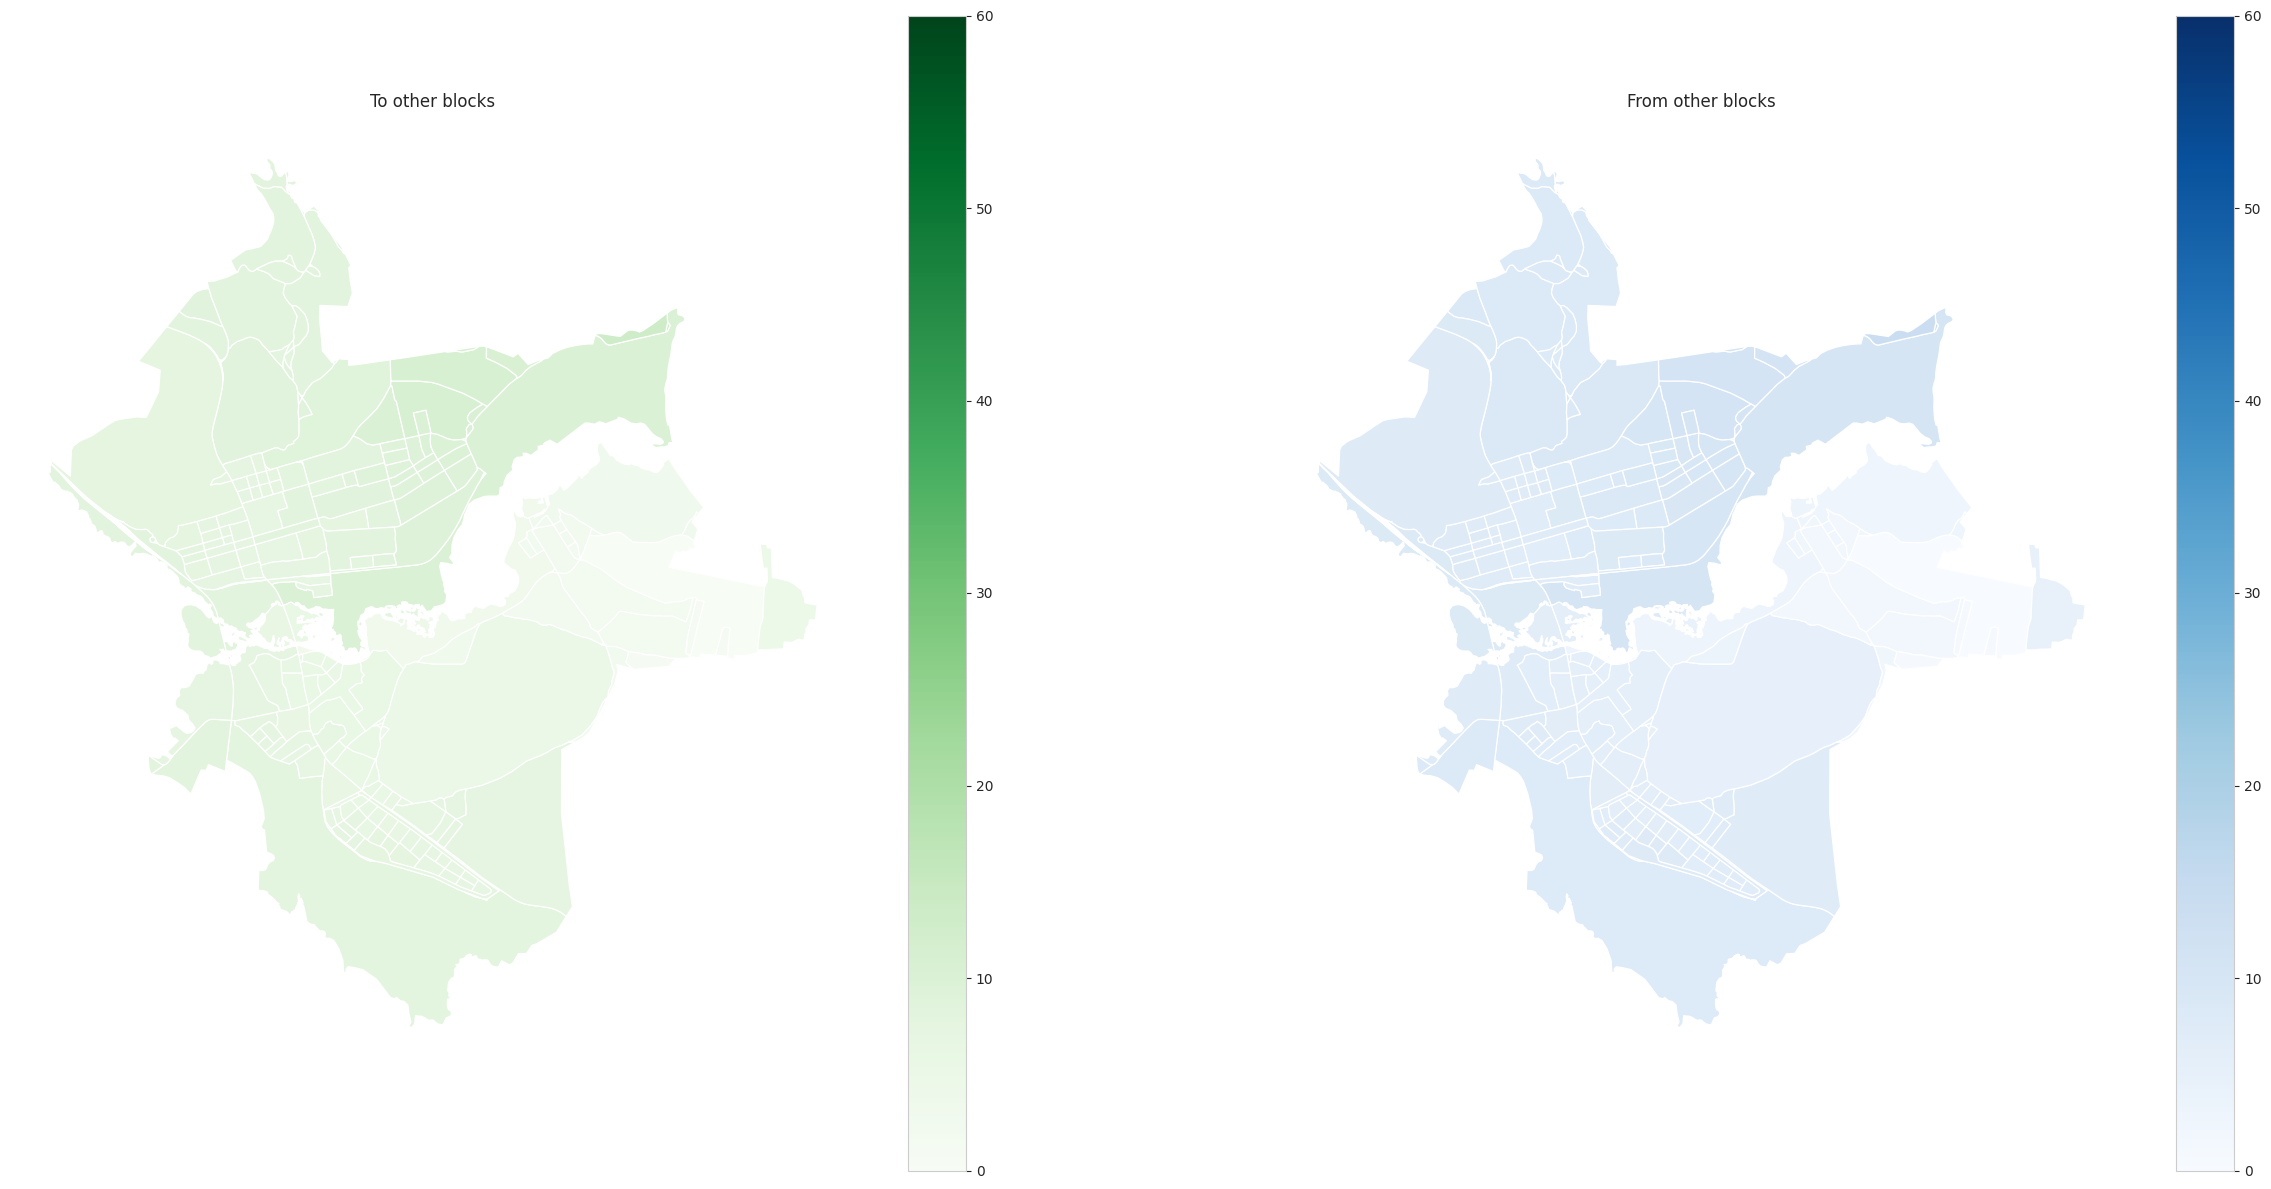

In [ ]:
Accessibility.plot(result, linewidth=0.9, figsize=(30,15))

In [ ]:
result.to_file(os.path.join(data_path, 'accessibility.geojson'))

In [ ]:
connectivity = Connectivity(city_model=city)
connectivity_result = connectivity.calculate()

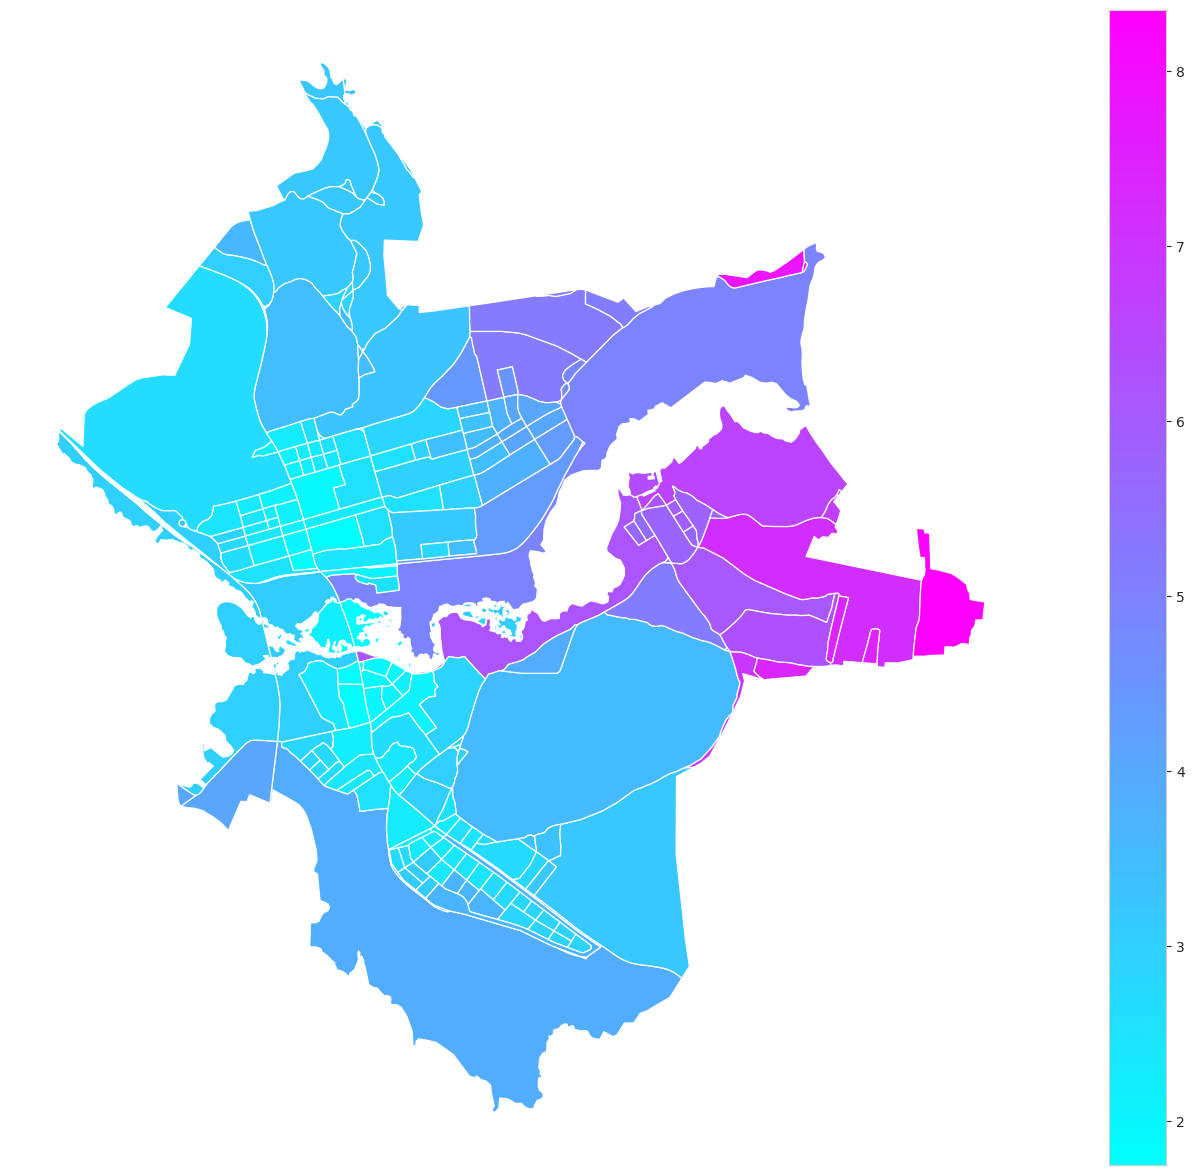

In [ ]:
Connectivity.plot(connectivity_result, linewidth=0.9, figsize=(20,15))

In [ ]:
connectivity_result.to_file(os.path.join(data_path, 'connectivity.geojson'))

Вы прошли квест!